In [366]:
from features_extraction import extract_features,generate_features_list,plot_leaf_and_features,wrap_generate_features_list

In [363]:
from tqdm import tqdm_notebook as tqdm

In [367]:
def save_features_list(ID=range(1,1585),scale=200,save_path='../middata/my_features.npy'):
    tmp_return = []
    for i in tqdm(range(len(ID))):
        tmp_feature = generate_features_list(ID)[0][i]
        shape_series_1 = tmp_feature['shape_series'][0]
        blade_series_1 = tmp_feature['blade_series'][0]
        shape_series_1 = shape_series_1[:scale]
        blade_series_1 = blade_series_1[:scale]
        tmp_return.append(np.vstack((shape_series_1,blade_series_1)))
        tmp_return = np.array(tmp_return)
        if save_path:
            np.save(save_path, tmp_return)
    return tmp_return

In [370]:
tmp,_ = generate_features_list(range(1,1585),False)

In [377]:
scale = 200
shape_and_blade_list = []
for tmp_feature in tmp:
    shape_series_1 = tmp_feature['shape_series'][0]
    blade_series_1 = tmp_feature['blade_series'][0]
    shape_series_1 = shape_series_1[:scale]
    blade_series_1 = blade_series_1[:scale]
#     shape_and_blade_list.append(np.vstack((shape_series_1,blade_series_1)).reshape((scale,2)))
    shape_and_blade_list.append(np.vstack((shape_series_1,blade_series_1)))


shape_and_blade_array = np.array(shape_and_blade_list)
np.save('../middata/my_features.npy',shape_and_blade_array)

In [378]:
shape_and_blade_array.shape

(1584, 2, 200)

In [371]:
tmp[0]

{'blade_center': (254.26113562034794, 267.3099485201401),
 'blade_contour': array([[503.49764706, 295.75078431],
        [502.24764706, 293.00078431],
        [502.7974902 , 289.99937255],
        ...,
        [500.3974902 , 304.59937255],
        [501.74764706, 301.49921569],
        [502.99811765, 298.3987451 ]]),
 'blade_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'blade_series': array([[18.29936558, 17.07699738, 17.71084897, ..., 15.41818556,
         16.55522299, 17.80827053],
        [ 2.        ,  3.        ,  3.        , ...,  0.        ,
          0.        ,  1.        ]]),
 'img_num': 1,
 'inversion_ix': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False

In [2]:
# imports
import numpy as np                     # numeric python lib

import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour

from skimage import measure            # to find shape contour
import scipy.ndimage as ndi            # to determine shape centrality
from math import floor


# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots

In [308]:
import random

def plot_a_contour(tmp_contour):
    plt.scatter(tmp_contour[:,1],tmp_contour[:,0],1)
    return

def plot_a_contour_from_ID(ID,contours):
    tmp_contour = a_ID_to_a_contour(ID,contours)
    plot_a_contour(tmp_contour)
    return


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return [rho, phi]

def pick_up_the_contour_in_a_special_scale(index_num,scale=200,plotit=''):
    """从一张图的边界点中取出一定规模的点"""
    img = mpimg.imread('../rawdata/images/' + str(index_num) + '.jpg')
    # 找质心
    cy, cx = ndi.center_of_mass(img)
    # 找轮廓
    contours = measure.find_contours(img, .8)
    # from which we choose the longest one
    contour = max(contours, key=len)

    contour[::,1] -= cx  # demean X
    contour[::,0] -= cy  # demean Y

    # just calling the transformation on all pairs in the set
    polar_contour = np.array([cart2pol(x, y) for x, y in contour])

    # 确定取点间隔
    interval = int(floor(len(polar_contour) / scale))
    tmp_contour = polar_contour[::interval]
#     out_polar_contour = random.sample(tmp_contour,scale)
    random_index = np.sort(random.sample(range(len(tmp_contour)),scale))
    out_polar_contour = tmp_contour[random_index]
    assert len(out_polar_contour) == scale, '还有点没删干净'

    if plotit == 'rho':
        plt.scatter(range(scale),out_polar_contour[:,0],1)
    if plotit == 'phi':
        plt.scatter(range(scale),out_polar_contour[:,1],1)
        
#     return out_polar_contour
    return np.array(out_polar_contour)

In [295]:
from sklearn.preprocessing import StandardScaler

def ID_list_to_contours(ID_list,scale=200,save_path=''):
    """将一个ID_list转化为一个标准化后的contours_array"""
    contours_list = []
    for id_index in ID_list:
        contours_list.append(pick_up_the_contour_in_a_special_scale(index_num=id_index+1, scale=scale, plotit=''))
        
    contours_array = np.array(contours_list)
    
    reshaped_tmp = contours_array.reshape((-1,2))
    transformer = StandardScaler().fit(reshaped_tmp)
    contours_array_standerdscalered = transformer.transform(reshaped_tmp).reshape((len(ID_list),scale,2))
    
    # 保存
    if save_path:
        np.save(save_path, contours_array_standerdscalered)
    return contours_array_standerdscalered, transformer

def a_ID_to_a_contour(ID,contours):
    return contours[ID-1]

In [309]:
tmp, transformer = ID_list_to_contours(range(100),scale=200,save_path='../middata/contours_array.npy')

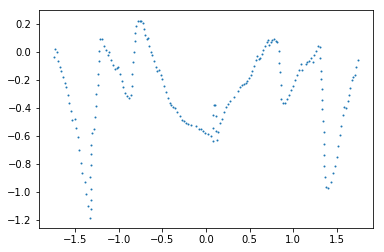

In [298]:
plot_a_contour(tmp[0])

In [246]:
tmp_1 = load_contours([5],'../middata/contours_array.npy')

In [165]:
num = 10
flip_degree = np.array(np.random.randint(low=0, high=4,size=(num))) * 90  # 上下翻转，左右翻转, 即数据增强的翻转方向
rotation_degree = np.random.randn(num) * 10
flip_and_rotation_degree = flip_degree + rotation_degree  # 需要旋转的角度
translation_distance = ((flip_and_rotation_degree / 360) * scale).astype(int)  # 需要平移的单位个数

print translation_distance

[155  -8  57  55 100  44  48  -2 108 147]


In [182]:
def contours_data_augmenter(ID, rotation_degree_ratio=10, larger_or_smaller_ratio=0.05):
    """
    ID: 是需要加强的一组数据，此处仅仅为了得到需要生成加强因子的规模
    rotation_degree_ratio: 随机旋转的角度，这里和外部保持一致，为10度
    larger_or_smaller_ratio: 随机增大减小的比例，这里默认取5%
    """
    length = len(ID)
    
    # 平移
    flip_degree = np.array(np.random.randint(low=0, high=4,size=(length))) * 90  # 上下翻转，左右翻转, 即数据增强的翻转方向
    rotation_degree = np.random.randn(length) * rotation_degree_ratio
    flip_and_rotation_degree = flip_degree + rotation_degree  # 需要旋转的角度
    translation_distance = ((flip_and_rotation_degree / 360) * scale).astype(int)  # 需要平移的单位个数

    # 扩大缩小
    random_larger_or_smaller = 1 + np.random.randn(length) * larger_or_smaller_ratio
    return translation_distance, random_larger_or_smaller

In [312]:
translation_distance, random_larger_or_smaller = contours_data_augmenter(range(10))

In [300]:
translation_distance

array([153,  86,   2,  96,  -6,   7,  -6,  45, -16,  -6])

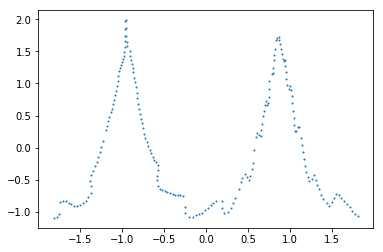

In [310]:
plot_a_contour(tmp_contours)

In [261]:
tmp_5 = [0,1,2,3,4]
tmp_5[-3:] + tmp_5[:-3]

[2, 3, 4, 0, 1]

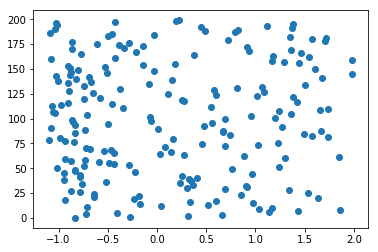

In [311]:
plt.scatter(tmp_contours[:,0],range(len(tmp_contours[:,0])))

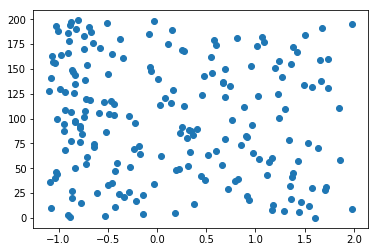

In [268]:
num = 50
tmp_contours_2 = tmp_contours.tolist()
tmp_contours_3 = tmp_contours_2[-num:] + tmp_contours_2[:-num]
tmp_q = np.array(tmp_contours_3)
plt.scatter(tmp_q[:,0],range(len(tmp_q[:,0])))

In [239]:
def load_contours(ID, contours_array_path):
    """通过ID数据将contour数据从contours_array中取出,并将序列随机平移、扩大缩小、对称"""
    contours_array = np.load(contours_array_path)
    translation_distance, random_larger_or_smaller = contours_data_augmenter(ID)
    # 对数据逐个进行随机增强
    contours = []
    for id_, trans_dis, rand_larger in zip(ID, translation_distance, random_larger_or_smaller):
        tmp_contours = contours_array[id_ - 1].tolist()  # 取出相应的原始contours数据
        tmp_contours = np.array(tmp_contours[-trans_dis:] + tmp_contours[:-trans_dis])  # 平移
        tmp_contours = tmp_contours * rand_larger
        contours.append(tmp_contours)
    
    return np.array(contours)

In [344]:
ID = np.arange(10) + 1
contours_array = np.load('../middata/contours_array.npy')
translation_distance, random_larger_or_smaller = contours_data_augmenter(ID)
# 对数据逐个进行随机增强
contours = []
for id_, trans_dis, rand_larger in zip(ID, translation_distance, random_larger_or_smaller):
    tmp_contours = contours_array[id_ - 1].tolist()  # 取出相应的原始contours数据
    tmp_contours = np.array(tmp_contours[-trans_dis:] + tmp_contours[:-trans_dis])  # 平移
    tmp_contours = tmp_contours * rand_larger
    contours.append(tmp_contours)

In [332]:
trans_dis

3

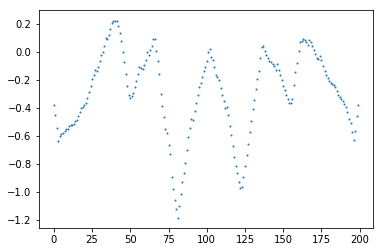

In [345]:
plt.scatter(range(len(contours_array[0,:,1])),contours_array[0,:,0],1)

In [346]:
contours = np.array(contours)

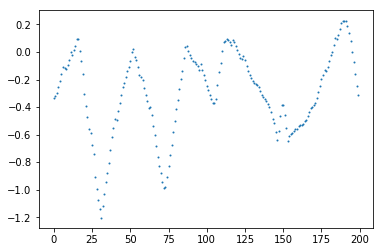

In [347]:
plt.scatter(range(len(contours[0,:,1])),contours[0,:,0],1)

In [349]:
type('') == str

True

In [ ]:
rand

In [313]:
tmp_1 = load_contours(range(10), '../middata/contours_array.npy')

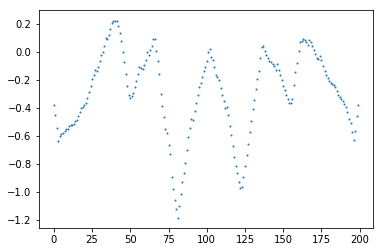

In [315]:
plt.scatter(range(len(tmp[0,:,1])),tmp[0,:,0],1)

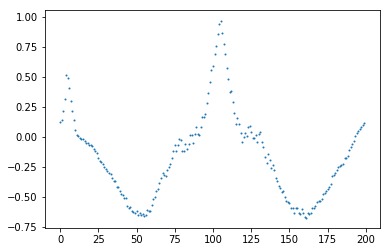

In [317]:
plt.scatter(range(len(tmp_1[1,:,1])),tmp_1[0,:,0],1)

In [202]:
contours_array = np.load('../middata/contours_array.npy')

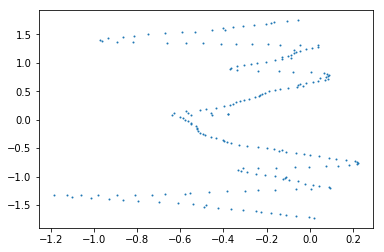

In [203]:
plt.scatter(contours_array[0,:,0],contours_array[0,:,1],1)

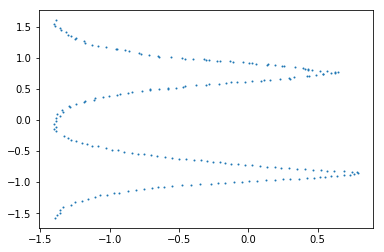

In [201]:
plt.scatter(tmp[0,:,0],tmp[0,:,1],1)

In [205]:
tmp[0]

array([[-0.79132136,  1.07989437],
       [-1.38671832, -0.01775323],
       [-0.89650446, -0.51159779],
       [-0.86080422,  1.09946431],
       [-0.77646455,  1.06123912],
       [-1.34301222,  0.16395091],
       [-1.36023849,  1.47848708],
       [-0.83888779, -0.52506392],
       [-1.39905073, -0.1508852 ],
       [ 0.33658525,  0.84352323],
       [-1.2833973 , -1.36495827],
       [ 0.29358538,  0.67129605],
       [ 0.45738104,  0.79607185],
       [-1.04584935,  0.36938442],
       [-0.40192477,  0.97174013],
       [-1.29149105,  0.22244613],
       [-0.65981473, -0.58766963],
       [ 0.06483913, -0.97487406],
       [ 0.57064383, -0.81572106],
       [-1.18053058,  1.23338458],
       [-0.28174563,  0.96135599],
       [-0.13123048,  0.94274522],
       [ 0.59987132, -0.90936588],
       [ 0.42349001, -0.93567146],
       [-0.12663705, -0.70316907],
       [ 0.59316806,  0.74688455],
       [-0.81086723, -1.1308042 ],
       [-0.39461618, -0.64047801],
       [-0.60263367,

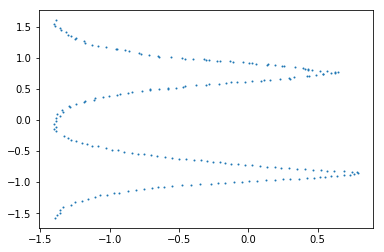

In [206]:
plt.scatter(tmp[0,:,0],tmp[0,:,1],1)

In [350]:
import pandas as pd
train_set = pd.read_csv('../rawdata/train.csv')

In [354]:
tmp = train_set.iloc[0].tolist()[2:]

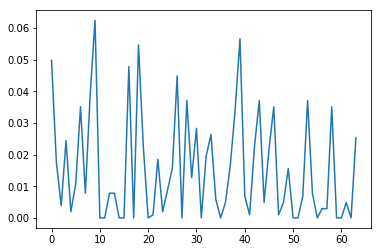

In [360]:
plt.plot(tmp[128:])